In [1]:
import pandas as pd 
from selenium import webdriver
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import re
import string
from skimage import io, transform
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [2]:
n_past = 5
n_future = 1

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
full_WP = pd.read_csv("./Full WP dataset.csv")

C:\Users\Louis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,8,9,14,25,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data Preprcoessing

In [6]:
full_WP = full_WP.iloc[1:]

In [7]:
full_WP = full_WP.loc[full_WP['SEASON'].astype(int) >= 2000]

In [8]:
columns_features = ['ISO_TIME', 'SEASON', 'NAME', 'USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']

In [9]:
full_WP_modify = full_WP[columns_features].copy()

In [10]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [11]:
full_WP_modify = full_WP_modify[full_WP_modify.NAME != 'NOT_NAMED']

In [12]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [13]:
full_WP_modify = full_WP_modify[full_WP_modify.USA_LAT!=' ']

In [14]:
full_WP_modify = full_WP_modify.replace(r'^\s*$', -1 , regex=True)

In [15]:
full_WP_modify['USA_LAT'] = full_WP_modify['USA_LAT'].astype(float)

In [16]:
full_WP_modify['USA_LON'] = full_WP_modify['USA_LON'].astype(float)

In [17]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [18]:
full_WP_modify['USA_LAT'].min()

1.3

In [19]:
full_WP_modify['USA_LAT'].max()

51.3

In [20]:
full_WP_modify['USA_LON'].min()

-180.0

In [21]:
full_WP_modify['USA_LON'].max()

180.0

In [22]:
full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360

C:\Users\Louis\AppData\Local\Temp/ipykernel_15468/916726116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360


In [23]:
# full_WP_modify = full_WP_modify.drop(full_WP_modify[full_WP_modify.USA_LON < 0].index)

In [24]:
full_WP_modify['USA_LON'].max()

244.9

In [25]:
full_WP_modify['USA_LON'].min()

78.6

In [26]:
long_range = full_WP_modify.index[full_WP_modify['USA_LON'] <0].tolist()

In [27]:
len(long_range)

0

In [28]:
dict_remove = {}
for i in long_range:
    print(i)
    name = full_WP_modify.iloc[i,2]
    year = full_WP_modify.iloc[i,1]
    dict_remove[year] = name

In [29]:
dict_remove

{}

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler_lat = MinMaxScaler()
scaler_long = MinMaxScaler()
scaler_dist = MinMaxScaler()
scaler_wind = MinMaxScaler()
scaler_pres = MinMaxScaler()
scaler_r34_ne = MinMaxScaler()
scaler_r34_se = MinMaxScaler()
scaler_r34_sw = MinMaxScaler()
scaler_r34_nw = MinMaxScaler()
scaler_r50_ne = MinMaxScaler()
scaler_r50_se = MinMaxScaler()
scaler_r50_sw = MinMaxScaler()
scaler_r50_nw = MinMaxScaler()
scaler_r64_ne = MinMaxScaler()
scaler_r64_se = MinMaxScaler()
scaler_r64_sw = MinMaxScaler()
scaler_r64_nw = MinMaxScaler()

In [31]:
full_WP_modify[['USA_LAT']] = scaler_lat.fit_transform(full_WP_modify[['USA_LAT']])
full_WP_modify[['USA_LON']] = scaler_long.fit_transform(full_WP_modify[['USA_LON']])
full_WP_modify[['DIST2LAND']] = scaler_dist.fit_transform(full_WP_modify[['DIST2LAND']])
full_WP_modify[['USA_WIND']] = scaler_wind.fit_transform(full_WP_modify[['USA_WIND']])
full_WP_modify[['USA_PRES']] = scaler_pres.fit_transform(full_WP_modify[['USA_PRES']])
full_WP_modify[['USA_R34_NE']] = scaler_r34_ne.fit_transform(full_WP_modify[['USA_R34_NE']])
full_WP_modify[['USA_R34_SE']] = scaler_r34_se.fit_transform(full_WP_modify[['USA_R34_SE']])
full_WP_modify[['USA_R34_SW']] = scaler_r34_sw.fit_transform(full_WP_modify[['USA_R34_SW']])
full_WP_modify[['USA_R34_NW']] = scaler_r34_nw.fit_transform(full_WP_modify[['USA_R34_NW']])
full_WP_modify[['USA_R50_NE']] = scaler_r50_ne.fit_transform(full_WP_modify[['USA_R50_NE']])
full_WP_modify[['USA_R50_SE']] = scaler_r50_se.fit_transform(full_WP_modify[['USA_R50_SE']])
full_WP_modify[['USA_R50_SW']] = scaler_r50_sw.fit_transform(full_WP_modify[['USA_R50_SW']])
full_WP_modify[['USA_R50_NW']] = scaler_r50_nw.fit_transform(full_WP_modify[['USA_R50_NW']])
full_WP_modify[['USA_R64_NE']] = scaler_r64_ne.fit_transform(full_WP_modify[['USA_R64_NE']])
full_WP_modify[['USA_R64_SE']] = scaler_r64_se.fit_transform(full_WP_modify[['USA_R64_SE']])
full_WP_modify[['USA_R64_SW']] = scaler_r64_sw.fit_transform(full_WP_modify[['USA_R64_SW']])
full_WP_modify[['USA_R64_NW']] = scaler_r64_nw.fit_transform(full_WP_modify[['USA_R64_NW']])

In [32]:
for year in range(2000,2022):
     globals()['df_WP_%s' % year] = full_WP_modify[(full_WP_modify["SEASON"]==year)]

In [33]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] = globals()['df_WP_%s' % year].reset_index(drop=True)

In [34]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] =  globals()['df_WP_%s' % year].drop(['SEASON'], axis=1)

In [35]:
for year in range(2000,2022):
    for i in range(len(globals()['df_WP_%s' % year])):
        globals()['df_WP_%s' % year].iloc[i,1] = re.sub(r"[^\w\s]", '',  globals()['df_WP_%s' % year].iloc[i,1])

In [36]:
summarylist = []
for year in range(2000,2022):
    summarylist.append(dict(tuple(globals()['df_WP_%s' % year].groupby('NAME'))))

In [37]:
tc_name_list = []
for i in range(len(summarylist)):
    tc_name_list.append(list(summarylist[i].keys()))

In [38]:
print(tc_name_list[0])

['BEBINCA', 'BILIS', 'BOLAVEN', 'BOPHA', 'CHANCHU', 'DAMREY', 'EWINIAR', 'JELAWAT', 'KAEMI', 'KAITAK', 'KIROGI', 'LONGWANG', 'MARIA', 'PRAPIROON', 'RUMBIA', 'SAOMAI', 'SHANSHAN', 'SONAMU', 'SOULIK', 'TEMBIN', 'WENE', 'WUKONG', 'XANGSANE', 'YAGI']


In [39]:
count = 0
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        count = count+1
        globals()['df_WP_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s' % (str(2000+i))][globals()['df_WP_%s' % (str(2000+i))].NAME == name]
#         globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)][globals()['df_WP_%s_%s'%((str(2000+i)),name)].USA_LAT != ' ']
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)] .reset_index(drop=True)

In [40]:
# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:
#         globals()['df_WP_%s_%s'%((str(2000+i)), name)] = (globals()['df_WP_%s_%s'%((str(2000+i)), name)]).drop(['NAME'], axis=1)

In [41]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_WP_%s_%s'%((str(2000+i)), name)].rename(columns={'ISO_TIME':'Date'}, inplace=True)
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'] = pd.to_datetime(globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'], dayfirst=True)

In [42]:
cols_features = list(df_WP_2018_MANGKHUT)[1:len(df_WP_2018_MANGKHUT.columns)]
print(cols_features)

['NAME', 'USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']


In [43]:
cols_target = list(df_WP_2018_MANGKHUT)[1:2]

In [44]:
cols_target

['NAME']

In [45]:
print(cols_features)
print(cols_target)

['NAME', 'USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['NAME']


In [46]:
# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:
#         globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
#         globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target].astype(float)

In [47]:
df_WP_2000_DAMREY

,Date,NAME,USA_LAT,USA_LON,DIST2LAND,USA_WIND,USA_PRES,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW
0,2000-05-03 18:00:00,DAMREY,0.098000,0.343355,0.243235,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-05-03 21:00:00,DAMREY,0.109451,0.342363,0.264317,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000-05-04 00:00:00,DAMREY,0.120000,0.341551,0.281938,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000-05-04 03:00:00,DAMREY,0.128900,0.341070,0.294210,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000-05-04 06:00:00,DAMREY,0.136000,0.340950,0.302077,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2000-05-12 00:00:00,DAMREY,0.528000,0.404089,0.309314,0.181287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,2000-05-12 03:00:00,DAMREY,0.533752,0.410595,0.317810,0.163743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,2000-05-12 06:00:00,DAMREY,0.538000,0.416115,0.328823,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,2000-05-12 09:00:00,DAMREY,0.539744,0.419934,0.340151,0.152047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
tc_name_list[18].remove('MANGKHUT')

In [49]:
tc_name_list[18].remove('KONGREY')

In [50]:
tc_name_list[18].remove('YUTU')

In [51]:
tc_name_list[19].remove('WUTIP')

In [52]:
count = 0

In [53]:
def get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future):
    global count
    features_list = []
    image_list = []
    count_photo =[]
    image_list_current = []
    for i in range(n_past):
        features_list_current = []
        image_list_current = []
        root_dir = "C:/Users/Louis/Full Typhoon Images/"
        # current_typhoon_name = df_WP_2000_DAMREY.iloc[idx,1]
        # current_timestamp_year = (str(df_WP_2000_DAMREY.iloc[idx,0]))[:4]
        folder = "(" + typhoon_name + ")_" + typhoon_year
        current_timestamp_date = (str(globals()['df_WP_%s_%s'% (typhoon_year, typhoon_name)].iloc[idx,0]))[:10]
        current_timestamp_hour = (str(globals()['df_WP_%s_%s'% (typhoon_year, typhoon_name)].iloc[idx,0]))[11:13]
        image_path = "(" + typhoon_name + ")_" + current_timestamp_date + "_" + current_timestamp_hour + ".png"
        img_name = os.path.join(root_dir, folder ,image_path).replace("\\","/")
        # print(img_name)
        try:
            # image_test = io.imread(img_name)
            scaler = transforms.Scale((224, 224))
            # normalize = transforms.Normalize((0.5), (0.5))
            normalize = transforms.Normalize((0.5), (0.5))
            to_tensor = transforms.ToTensor()
            
            image_test = Image.open(img_name)
            image = Variable(normalize(to_tensor(scaler(image_test))).unsqueeze(0))
            
            # image_test = Image.open(img_name).convert('RGB')
            # image_test = np.array(image_test)
            # image_test = np.rollaxis(image_test, 2, 0)
        
            # print(image.shape)
            # current_image_vector = get_vector(img_name)
            # current_image_vector = current_image_vector.numpy()
            # print("OK")
            count = count+1
            # print(count)
            # print(typhoon_name)
            # print(typhoon_year)
            # print("read image")
        except FileNotFoundError:
            # print("FileNotFoundError")
            # print(typhoon_name)
            # print(typhoon_year)
            # print(current_timestamp_date)
            # print("No satelite image for this timestamp")
            # image = "no_image"
            image = torch.zeros(1, 1,224,224)
            # print(image.shape)

        for j in range(17):
            features_list_current.append(globals()['df_WP_%s_%s'% (typhoon_year, typhoon_name)].iloc[idx,j+2])
        image_list_current.append(image)
        
        features_list.append(features_list_current)
        image_list.append(image_list_current)
    
        # features_list = np.array(features_list, dtype=np.float32)
        # image_list = np.array(image_list, dtype=np.float32)
        
        # all_features_numpy = np.concatenate((features_list_current, current_image_vector), axis=0)
        # feature_list.append(all_features_numpy)
        # image_list.append(typhoon_image_current_timestamp)
        # typhoon_dict['features'].append(features_list_current)
        # typhoon_dict['typhoon_image'].append(typhoon_image_current_timestamp)
        idx += 1
    target_latitude = globals()['df_WP_%s_%s'% (typhoon_year, typhoon_name)].iloc[idx,2]
    target_longitude =  globals()['df_WP_%s_%s'% (typhoon_year, typhoon_name)].iloc[idx,3]
    return features_list, image_list, target_latitude, target_longitude,count

In [54]:


all_features_typhoon_data=[]
all_target_typhoon_lat=[]
all_target_typhoon_long=[]
for i in range(len(tc_name_list)):
# for i in range(1):
    for typhoon_name in tc_name_list[i]:
        idx=0
        typhoon_year = str(2000 + i)
        # print(typhoon_year)
        # print(typhoon_name)
        while True:
            try:
                list_1, list_2, lat,long, count = get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future)
                features_tensor = torch.FloatTensor(list_1)
                image_path = list_2
                lat_tensor = torch.from_numpy(np.array(lat, dtype="float32"))
                long_tensor = torch.from_numpy(np.array(long, dtype="float32"))

                
                # print("doing")
                typhoon_features_dict = {'features': features_tensor,
                                'images': image_path}
                
                typhoon_target_lat = {'latitude':lat_tensor}
                typhoon_target_long = {'longitude':long_tensor}

                all_features_typhoon_data.append(typhoon_features_dict)
                all_target_typhoon_lat.append(typhoon_target_lat)
                all_target_typhoon_long.append(typhoon_target_long)
                
                idx += 1
                list_1 = []
                list_2 = []
                lat = 0 
                long = 0
            except IndexError:
                print("no more timestamp")
                break

C:\Users\Louis\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more timestamp
no more ti

In [55]:
all_features_typhoon_data_MANGKHUT=[]
all_target_typhoon_lat_MANGKHUT=[]
all_target_typhoon_long_MANGKHUT=[]

typhoon_name = 'MANGKHUT'
idx=0
typhoon_year = str(2000 + 18)
# print(typhoon_year)
# print(typhoon_name)
while True:
    try:
        list_1, list_2, lat,long, count = get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future)
        features_tensor = torch.FloatTensor(list_1)
        image_path = list_2
        lat_tensor = torch.from_numpy(np.array(lat, dtype="float32"))
        long_tensor = torch.from_numpy(np.array(long, dtype="float32"))


        # print("doing")
        typhoon_features_dict_MANGKHUT = {'features': features_tensor,
                        'images': image_path}

        typhoon_target_lat_MANGKHUT = {'latitude':lat_tensor}
        typhoon_target_long_MANGKHUT = {'longitude':long_tensor}

        all_features_typhoon_data_MANGKHUT.append(typhoon_features_dict_MANGKHUT)
        all_target_typhoon_lat_MANGKHUT.append(typhoon_target_lat_MANGKHUT)
        all_target_typhoon_long_MANGKHUT.append(typhoon_target_long_MANGKHUT)

        idx += 1
        list_1 = []
        list_2 = []
        lat = 0 
        long = 0
    except IndexError:
        print("no more timestamp")
        break

no more timestamp


In [56]:
all_features_typhoon_data_KONGREY=[]
all_target_typhoon_lat_KONGREY=[]
all_target_typhoon_long_KONGREY=[]

typhoon_name = 'KONGREY'
idx=0
typhoon_year = str(2000 + 18)
# print(typhoon_year)
# print(typhoon_name)
while True:
    try:
        list_1, list_2, lat,long, count = get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future)
        features_tensor = torch.FloatTensor(list_1)
        image_path = list_2
        lat_tensor = torch.from_numpy(np.array(lat, dtype="float32"))
        long_tensor = torch.from_numpy(np.array(long, dtype="float32"))


        # print("doing")
        typhoon_features_dict_KONGREY = {'features': features_tensor,
                        'images': image_path}

        typhoon_target_lat_KONGREY = {'latitude':lat_tensor}
        typhoon_target_long_KONGREY = {'longitude':long_tensor}

        all_features_typhoon_data_KONGREY.append(typhoon_features_dict_KONGREY)
        all_target_typhoon_lat_KONGREY.append(typhoon_target_lat_KONGREY)
        all_target_typhoon_long_KONGREY.append(typhoon_target_long_KONGREY)

        idx += 1
        list_1 = []
        list_2 = []
        lat = 0 
        long = 0
    except IndexError:
        print("no more timestamp")
        break

no more timestamp


In [57]:
all_features_typhoon_data_YUTU=[]
all_target_typhoon_lat_YUTU=[]
all_target_typhoon_long_YUTU=[]

typhoon_name = 'YUTU'
idx=0
typhoon_year = str(2000 + 18)
# print(typhoon_year)
# print(typhoon_name)
while True:
    try:
        list_1, list_2, lat,long, count = get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future)
        features_tensor = torch.FloatTensor(list_1)
        image_path = list_2
        lat_tensor = torch.from_numpy(np.array(lat, dtype="float32"))
        long_tensor = torch.from_numpy(np.array(long, dtype="float32"))


        # print("doing")
        typhoon_features_dict_YUTU = {'features': features_tensor,
                        'images': image_path}

        typhoon_target_lat_YUTU = {'latitude':lat_tensor}
        typhoon_target_long_YUTU = {'longitude':long_tensor}

        all_features_typhoon_data_YUTU.append(typhoon_features_dict_YUTU)
        all_target_typhoon_lat_YUTU.append(typhoon_target_lat_YUTU)
        all_target_typhoon_long_YUTU.append(typhoon_target_long_YUTU)

        idx += 1
        list_1 = []
        list_2 = []
        lat = 0 
        long = 0
    except IndexError:
        print("no more timestamp")
        break

no more timestamp


In [58]:
all_features_typhoon_data_WUTIP=[]
all_target_typhoon_lat_WUTIP=[]
all_target_typhoon_long_WUTIP=[]

typhoon_name = 'WUTIP'
idx=0
typhoon_year = str(2000 + 19)
# print(typhoon_year)
# print(typhoon_name)
while True:
    try:
        list_1, list_2, lat,long, count = get_typhoon_data(typhoon_name, typhoon_year, idx , n_past, n_future)
        features_tensor = torch.FloatTensor(list_1)
        image_path = list_2
        lat_tensor = torch.from_numpy(np.array(lat, dtype="float32"))
        long_tensor = torch.from_numpy(np.array(long, dtype="float32"))


        # print("doing")
        typhoon_features_dict_WUTIP = {'features': features_tensor,
                        'images': image_path}

        typhoon_target_lat_WUTIP = {'latitude':lat_tensor}
        typhoon_target_long_WUTIP = {'longitude':long_tensor}

        all_features_typhoon_data_WUTIP.append(typhoon_features_dict_WUTIP)
        all_target_typhoon_lat_WUTIP.append(typhoon_target_lat_WUTIP)
        all_target_typhoon_long_WUTIP.append(typhoon_target_long_WUTIP)

        idx += 1
        list_1 = []
        list_2 = []
        lat = 0 
        long = 0
    except IndexError:
        print("no more timestamp")
        break

no more timestamp


In [59]:
len(all_features_typhoon_data_MANGKHUT)

90

In [60]:
len(all_target_typhoon_lat_MANGKHUT)

90

In [61]:
len(all_target_typhoon_long_MANGKHUT)

90

In [62]:
len(all_features_typhoon_data)

28712

In [63]:
len(all_target_typhoon_lat)

28712

In [64]:
trainX_lat, valX_lat = all_features_typhoon_data[:(int(len(all_features_typhoon_data) * 0.8))], all_features_typhoon_data[(int(len(all_features_typhoon_data) * 0.8)):]
trainY_lat, valY_lat = all_target_typhoon_lat[:(int(len(all_target_typhoon_lat) * 0.8))], all_target_typhoon_lat[(int(len(all_target_typhoon_lat) * 0.8)):]
valX_lat, testX_lat = valX_lat[:(int(len(valX_lat) * 0.5))], valX_lat[(int(len(valX_lat) * 0.5)):]
valY_lat, testY_lat = valY_lat[:(int(len(valY_lat) * 0.5))], valY_lat[(int(len(valY_lat) * 0.5)):]

In [65]:
trainX_long, valX_long = all_features_typhoon_data[:(int(len(all_features_typhoon_data) * 0.8))], all_features_typhoon_data[(int(len(all_features_typhoon_data) * 0.8)):]
trainY_long, valY_long = all_target_typhoon_lat[:(int(len(all_target_typhoon_lat) * 0.8))], all_target_typhoon_lat[(int(len(all_target_typhoon_lat) * 0.8)):]
valX_long, testX_long = valX_long[:(int(len(valX_long) * 0.5))], valX_long[(int(len(valX_long) * 0.5)):]
valY_long, testY_long = valY_long[:(int(len(valY_long) * 0.5))], valY_long[(int(len(valY_long) * 0.5)):]

In [66]:
print(len(trainX_long))
print(len(valX_long))
print(len(testX_long))

22969
2871
2872


In [67]:
print(len(trainX_lat))
print(len(valX_lat))
print(len(testX_lat))

22969
2871
2872


In [68]:
train_set_with_lat = [trainX_lat, trainY_lat]

In [69]:
val_set_with_lat = [valX_lat, valY_lat]

In [70]:
test_set_with_lat = [testX_lat, testY_lat]

In [71]:
train_set_with_long = [trainX_long, trainY_long]

In [72]:
val_set_with_long = [valX_long, valY_long]

In [73]:
test_set_with_long = [testX_long, testY_long]

In [74]:
MANGKHUT_set_lat = [all_features_typhoon_data_MANGKHUT, all_target_typhoon_lat_MANGKHUT]
MANGKHUT_set_long = [all_features_typhoon_data_MANGKHUT, all_target_typhoon_long_MANGKHUT]

In [75]:
KONGREY_set_lat = [all_features_typhoon_data_KONGREY, all_target_typhoon_lat_KONGREY]
KONGREY_set_long = [all_features_typhoon_data_KONGREY, all_target_typhoon_long_KONGREY]

In [76]:
YUTU_set_lat = [all_features_typhoon_data_YUTU, all_target_typhoon_lat_YUTU]
YUTU_set_long = [all_features_typhoon_data_YUTU, all_target_typhoon_long_YUTU]

In [77]:
WUTIP_set_lat = [all_features_typhoon_data_WUTIP, all_target_typhoon_lat_WUTIP]
WUTIP_set_long = [all_features_typhoon_data_WUTIP, all_target_typhoon_long_WUTIP]

In [78]:
from torch.utils.data import Dataset,DataLoader
import cv2
import tensorflow as tf

In [79]:
class CustomTensorDataset(Dataset):
  def __init__(self, dataset, transform_list=None):
    [data_X, data_y] = dataset
    #X_tensor, y_tensor = Tensor(data_X), Tensor(data_y)
    tensors = (data_X, data_y)
    assert all(len(tensors[0]) == len(tensor) for tensor in tensors)
    self.tensors = tensors
    
  def __getitem__(self, index):
    x = self.tensors[0][index]
    y = self.tensors[1][index]
    
    tmp_img_data = []
    images_data = []
    
    for image_name in x['images']:
        
        tmp_img_data.append(image_name)
        
    images_data.append(tmp_img_data)

    
    inputs = {
        'features': x['features'],
        'images': images_data
    }
        
    # print(x)
    # print(y)
    
    return inputs, y

  def __len__(self):
    return len(self.tensors[0])

In [80]:
train_set_lstm = CustomTensorDataset(dataset=train_set_with_lat)

In [81]:
val_set_lstm = CustomTensorDataset(dataset=val_set_with_lat)

In [82]:
test_set_lstm = CustomTensorDataset(dataset=test_set_with_lat)

In [83]:
train_set_lstm_long = CustomTensorDataset(dataset=train_set_with_long)

In [84]:
val_set_lstm_long = CustomTensorDataset(dataset=val_set_with_long)

In [85]:
test_set_lstm_long = CustomTensorDataset(dataset=test_set_with_long)

In [86]:
MANGKHUT_set_lstm_lat = CustomTensorDataset(dataset=MANGKHUT_set_lat)
MANGKHUT_set_lstm_long = CustomTensorDataset(dataset=MANGKHUT_set_long)

In [87]:
KONGREY_set_lstm_lat = CustomTensorDataset(dataset=KONGREY_set_lat)
KONGREY_set_lstm_long = CustomTensorDataset(dataset=KONGREY_set_long)

In [88]:
YUTU_set_lstm_lat = CustomTensorDataset(dataset=YUTU_set_lat)
YUTU_set_lstm_long = CustomTensorDataset(dataset=YUTU_set_long)

In [89]:
WUTIP_set_lstm_lat = CustomTensorDataset(dataset=WUTIP_set_lat)
WUTIP_set_lstm_long = CustomTensorDataset(dataset=WUTIP_set_long)

### DataLoader from dictionary

In [90]:
validation_list = []

In [91]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim_met, output_dim_met, input_dim_image, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        #fc 17 ->512
        self.fc_feature_met_expansion = nn.Linear(input_dim_met, output_dim_met)
        
        input_dim = output_dim_met + input_dim_image
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        # split 529 features into 17 + 512
        # 512 --> 32 dimensions

        #################################### positional encoding
        
    
        # print("x entering forward: ", x)
        # print(x.shape)
        # print(x[0][0][:17])
        
        # print("original x : ", x.shape)
        
        final_feature_list = []
        for i in range(x.shape[0]):
            int_list = []
            for j in range(x.shape[1]):
                up_features_met = self.fc_feature_met_expansion(x[i][j][:17])
                # print(up_features_met.shape)
                # print("upfeatures: ", up_features_met)
                image_feature = x[i][j][17:]
                # print(image_feature.shape)
                # print('image: ',image_feature)
                x_final = torch.cat([up_features_met, image_feature]).to(device)
                # print(x_final.shape)
                int_list.append(x_final)
                #print(int_list)
            x_final = (torch.stack((int_list[0], int_list[1], int_list[2], int_list[3], int_list[4]), 0))
            x_final = x_final[None,:,:]
            #print(x_final)
            # print(x_final.shape)
            final_feature_list.append(x_final)
        
        #print(final_feature_list)
    
        first_feature_tensor = final_feature_list[0]
        for i in range(len(final_feature_list)):
            if i < (len(final_feature_list) - 1):
                final_feature_tensor = torch.cat([first_feature_tensor, final_feature_list[i+1]], dim=0)
                first_feature_tensor = final_feature_tensor
        x_final = final_feature_tensor
        
        #print("final entering ", x_final)

        # print('Final x : ', x_final.shape)
    # def forward(self, x):
        
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x_final.size(0), self.hidden_dim, device=x_final.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x_final.size(0), self.hidden_dim, device=x_final.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x_final, (h0.detach(), c0.detach()))
        
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        
        return out

In [92]:
class Optimization_Lat:
    def __init__(self, model, loss_fn, optimizer, resnet_model):
        self.model = model
        #self.resnet = image_ex_model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.model_resnet = resnet_model.to(device)
        self.model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer = self.model_resnet._modules.get('avgpool')

    def Resnet(self,image):
        # print(t_img)
        # 3. Create a vector of zeros that will hold our feature vector
        #    The 'avgpool' layer has an output size of 512
        my_embedding = torch.zeros(512)
        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            my_embedding.copy_(o.data.reshape(o.data.size(1)))
        # 5. Attach that function to our selected layer
        h = self.layer.register_forward_hook(copy_data)
        # 6. Run the model on our transformed image
        self.model_resnet = self.model_resnet.to(device)
        self.model_resnet(image.to(device))
        # 7. Detach our copy function from the layer
        h.remove()
        # 8. Return the feature vector
        return my_embedding
    
    def tensor_concat(self,typhoon_features, typhoon_images, batch):
        
        final_tensor_list = []
        for bat in range(batch):
            # print("Batch size: ", bat)
            image_feature_model = []
            for i in range(len(typhoon_images[0])):
                image_Feature = self.Resnet(typhoon_images[0][i][0][bat].to(device))
                # print("Individual: ", image_Feature)
                image_feature_model.append(image_Feature)

            # print("Group: ", image_feature_model)
            
            image_tensor = torch.stack((image_feature_model[0], image_feature_model[1], image_feature_model[2], image_feature_model[3], image_feature_model[4]), 0)
            image_tensor = image_tensor[None,:,:]
            
            
            # print("image tensor", image_tensor.data[0])       
#             # print(typhoon_features.shape)
            # print('features: ', typhoon_features.data[bat])

            merge_image_and_feature_list = []
            for i in range(len(typhoon_features.data[0])):
                merge_image_and_feature = torch.concat((typhoon_features.data[bat][i].to(device), image_tensor.data[0][i].to(device)), 0)
                # print(merge_image_and_feature.shape)
                merge_image_and_feature_list.append(merge_image_and_feature)

            final_tensor = torch.stack((merge_image_and_feature_list[0], merge_image_and_feature_list[1], merge_image_and_feature_list[2], merge_image_and_feature_list[3], merge_image_and_feature_list[4]), 0)

            final_tensor = final_tensor[None,:,:]
            
            
            # print("final tensor: ", final_tensor)
            # print(final_tensor)
            # print(final_tensor.shape)
            final_tensor_list.append(final_tensor)

        return final_tensor_list
        
    
    def train_step(self, typhoon_features, typhoon_images, y, batch):
        
        
        # print("first feature: ", typhoon_features)
        
        # Sets model to train mode
        self.model.train()
            
        final_tensor_list = self.tensor_concat(typhoon_features,typhoon_images, batch)
                
        y = y[None,:].to(device)
        
        y =torch.transpose(y, 0, 1)
        
        # print("real y :", y.shape)
    
        # Makes predictions                
        first_tensor = final_tensor_list[0]
        for i in range(len(final_tensor_list)):
            if i < (len(final_tensor_list) - 1):
                # print(i)
                final_tensor = torch.cat([first_tensor, final_tensor_list[i+1]], dim=0)
                first_tensor = final_tensor
        
        # print(final_tensor.shape)
        
        final_tensor = final_tensor.to(device)
        
        final_yhat = self.model(final_tensor)
        
        # print("yhat: ", final_yhat.shape)
        
        
#         yhat_list = []
#         for i in range(len(final_tensor_list)):
#             yhat = self.model(final_tensor_list[i].to(device))
#             yhat_list.append(yhat)
        
#         prev_yhat = yhat_list[0]
#         for i in range(len(yhat_list)):
#             if i<(len(yhat_list)-1):
#                 final_yhat = torch.cat((prev_yhat, yhat_list[i+1]), 1)
#                 prev_yhat = final_yhat
            
        
        #Computes loss
        loss = self.loss_fn(y, final_yhat)  #yhat + x0 (lat/long)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size, n_epochs):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        model_path = "model_lat"
        previous_validation_loss = 100
        patience = 5
        count = 0
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                # print(x_batch['features'])
                # print(x_batch['images'])     
                # print('Y batch',y_batch)
                x_batch = x_batch
                y_batch = y_batch
                x_batch['features'] = x_batch['features'].view([batch_size, n_past, 17])
                
                y_batch = y_batch['latitude']
                
                # x_batch = x_batch.view([batch_size, 5, n_features])
                # print(x_batch['images'])
                
                # print(x_batch)
                # print(y_batch)
                # print("y_batch:", y_batch)
                
                loss = self.train_step(x_batch['features'],x_batch['images'], y_batch, batch_size)
                
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            print(training_loss)
            
            
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val['features'] = x_val['features'].view([batch_size, n_past, 17]).to(device)
                    y_val = y_val['latitude'].to(device)
                    y_val = y_val[None,:].to(device)
                    final_tensor_list_val = self.tensor_concat(x_val['features'],x_val['images'], batch_size)

                    y_val =torch.transpose(y_val, 0, 1)

                    # Makes predictions                
                    first_tensor_val = final_tensor_list_val[0]
                    for i in range(len(final_tensor_list_val)):
                        if i < (len(final_tensor_list_val) - 1):
                            final_tensor_val = torch.cat([first_tensor_val, final_tensor_list_val[i+1]], dim=0)
                            first_tensor_val = final_tensor_val
                    
                            
                    final_tensor_val = final_tensor_val.to(device)
                    
                    self.model.eval()
                    final_yhat_val = self.model(final_tensor_val)
                    
                    val_loss = self.loss_fn(y_val, final_yhat_val).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}")
                validation_list.append(validation_loss)
                validation_list.sort()
                if validation_loss <= validation_list[0]:
                    torch.save(self.model, model_path)
                    print("Updated best model")
                if validation_loss > previous_validation_loss:
                    count +=1
                    print("Current Validation_loss is greater than Previous Validation Loss, counting:", count)
                    if count>=patience:
                        print("Early stopping executed!")
                        break
                else:
                    print("Continue progress to global minima")
                    count = 0
                previous_validation_loss = validation_loss 

        # torch.save(self.model.state_dict(), model_path) 
        
    
    def evaluate(self, test_loader, batch_size, n_features):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test['features'] = x_test['features'].view([batch_size, n_past, n_features]).to(device)
                y_test = y_test['latitude'].to(device)
                y_test = y_test[None,:].to(device)
                final_tensor_list_test = self.tensor_concat(x_test['features'],x_test['images'], batch_size)
                
                y_test =torch.transpose(y_test, 0, 1)
                
                
                # Makes predictions                
                first_tensor_test = final_tensor_list_test[0]
                for i in range(len(final_tensor_list_test)):
                    if i < (len(final_tensor_list_test) - 1):
                        final_tensor_test = torch.cat([first_tensor_test, final_tensor_list_test[i+1]], dim=0)
                        first_tensor_test = final_tensor_test                    
                            
                final_tensor_test = final_tensor_test.to(device)
                
                self.model.eval()
                yhat_test = self.model(final_tensor_test)
                predictions.append(yhat_test.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [93]:
def get_model(model, model_params):
    models = {"lstm": LSTMModel}
    return models.get(model.lower())(**model_params)

In [94]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

input_dim_met = 17
output_dim_met = 512
input_dim_image = 512 
output_dim = 1
layer_dim = 1
dropout = 0
n_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-6

batch_size = [16]
hidden_dim = [128]
learning_rate = [0.001]
    
for batch in batch_size:
    for hd in hidden_dim:
        for lr in learning_rate:
            print("Batch: ", batch, " ", " Hidden dim: ", hd, " ", "Learning rate: ", lr)
            # shuffle = true
            
            train_loader = DataLoader(train_set_lstm, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_set_lstm, batch_size=batch, shuffle=True, drop_last=True)
            test_loader = DataLoader(test_set_lstm, batch_size=batch, shuffle=True, drop_last=True)
            
            MANGKHUT_loader = DataLoader(MANGKHUT_set_lstm_lat, batch_size=batch, shuffle=False, drop_last=True)
            KONGREY_loader = DataLoader(KONGREY_set_lstm_lat, batch_size=batch, shuffle=False, drop_last=True)
            YUTU_loader = DataLoader(YUTU_set_lstm_lat, batch_size=batch, shuffle=False, drop_last=True)
            WUTIP_loader = DataLoader(WUTIP_set_lstm_lat, batch_size=batch, shuffle=False, drop_last=True)
            

            model_params = {'input_dim_met': input_dim_met,
                            'output_dim_met': output_dim_met,
                            'input_dim_image': input_dim_image,
                            'hidden_dim' : hd,
                            'layer_dim' : layer_dim,
                            'output_dim' : output_dim,
                            'dropout_prob' : dropout }

            model = get_model('lstm', model_params).to(device)
            Resnet_model = models.resnet18(pretrained=True).to(device)
            
            loss_fn = nn.MSELoss(reduction="mean")
            optimizer = optim.Adam([{"params": Resnet_model.parameters(), "params": model.parameters()}], lr=lr, weight_decay=weight_decay)
            opt_lat = Optimization_Lat(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer,resnet_model=Resnet_model.to(device))
            opt_lat.train(train_loader, val_loader, batch, n_epochs)
            
            predictions, values = opt_lat.evaluate(test_loader, batch, input_dim_met)
            predictions_MANGKHUT, values_MANGKHUT = opt_lat.evaluate(MANGKHUT_loader, batch, input_dim_met)
            predictions_KONGREY, values_KONGREY = opt_lat.evaluate(KONGREY_loader, batch, input_dim_met)
            predictions_YUTU, values_YUTU = opt_lat.evaluate(YUTU_loader, batch, input_dim_met)
            predictions_WUTIP, values_WUTIP = opt_lat.evaluate(WUTIP_loader, batch, input_dim_met)
            
            opt_lat.plot_losses()

Batch:  16    Hidden dim:  128   Learning rate:  0.001


KeyboardInterrupt: 

In [137]:
train_loader = DataLoader(train_set_lstm, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set_lstm, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set_lstm, batch_size=16, shuffle=True, drop_last=True)

MANGKHUT_loader = DataLoader(MANGKHUT_set_lstm_lat, batch_size=16, shuffle=False, drop_last=True)
KONGREY_loader = DataLoader(KONGREY_set_lstm_lat, batch_size=16, shuffle=False, drop_last=True)
YUTU_loader = DataLoader(YUTU_set_lstm_lat, batch_size=16, shuffle=False, drop_last=True)
WUTIP_loader = DataLoader(WUTIP_set_lstm_lat, batch_size=16, shuffle=False, drop_last=True)

In [138]:
model_lat = torch.load('model_lat')

In [139]:
loss_fn = nn.MSELoss(reduction="mean")
Resnet_model = models.resnet18(pretrained=True).to(device)
optimizer = optim.Adam([{"params": Resnet_model.parameters(), "params": model_lat.parameters()}], lr=0.001, weight_decay=1e-6)
opt_lat = Optimization_Lat(model=model_lat, loss_fn=loss_fn, optimizer=optimizer,resnet_model=Resnet_model.to(device))

In [140]:
predictions, values = opt_lat.evaluate(test_loader, 16, 17)

In [141]:
len(predictions)

179

In [142]:
len(values)

179

In [143]:
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()

In [144]:
vals.shape

(2864,)

In [145]:
for i in range(len(vals)):
    vals[i] = scaler_lat.inverse_transform(vals[i].reshape(1, -1))

In [146]:
preds.shape

(2864,)

In [147]:
for i in range(len(preds)):
    preds[i] = scaler_lat.inverse_transform(preds[i].reshape(1, -1))

In [148]:
vals.shape

(2864,)

In [149]:
preds.shape

(2864,)

In [150]:
from sklearn.metrics import mean_squared_error
import math

In [151]:
print(mean_squared_error(vals, preds))
print(math.sqrt(mean_squared_error(vals, preds)))

0.07704407
0.2775681353595875


In [152]:
%store -r vals_from_long

In [153]:
vals_from_long

array([126.299995, 130.6     , 124.76501 , ..., 126.299995, 142.67    ,
       142.087   ], dtype=float32)

In [154]:
%store -r preds_from_long

In [155]:
vals_from_long = vals_from_long[:,None]

In [156]:
preds_from_long = preds_from_long[:,None]

In [157]:
preds = preds[:,None]

In [158]:
vals = vals[:,None]

In [159]:
pred_2 = np.concatenate((preds, preds_from_long), axis=1)

In [160]:
true_2 = np.concatenate((vals, vals_from_long), axis=1)

In [161]:
print(math.sqrt(mean_squared_error(true_2, pred_2)))

0.6422717398828136


### latitude testing

In [162]:
predictions, values = opt_lat.evaluate(test_loader, 16, 17)
predictions_MANGKHUT, values_MANGKHUT = opt_lat.evaluate(MANGKHUT_loader, 16, 17)
predictions_KONGREY, values_KONGREY = opt_lat.evaluate(KONGREY_loader, 16, 17)
predictions_YUTU, values_YUTU = opt_lat.evaluate(YUTU_loader, 16, 17)
predictions_WUTIP, values_WUTIP = opt_lat.evaluate(WUTIP_loader, 16, 17)

In [163]:
def latitude_outcome(value, pred):
    vals_MANGKHUT = np.concatenate(value, axis=0).ravel()
    preds_MANGKHUT = np.concatenate(pred, axis=0).ravel()
    for i in range(len(vals_MANGKHUT)):
        vals_MANGKHUT[i] = scaler_lat.inverse_transform(vals_MANGKHUT[i].reshape(1, -1))
    for i in range(len(preds_MANGKHUT)):
        preds_MANGKHUT[i] = scaler_lat.inverse_transform(preds_MANGKHUT[i].reshape(1, -1))
    return vals_MANGKHUT,preds_MANGKHUT

In [164]:
vals_mang_lat, pred_mang_lat = latitude_outcome(values_MANGKHUT, predictions_MANGKHUT)

In [165]:
print(mean_squared_error(vals_mang_lat, pred_mang_lat))
print(math.sqrt(mean_squared_error(vals_mang_lat, pred_mang_lat)))

0.022344563
0.1494809792460778


In [166]:
vals_kong_lat, pred_kong_lat = latitude_outcome(values_KONGREY, predictions_KONGREY)

In [167]:
print(mean_squared_error(vals_kong_lat, pred_kong_lat))
print(math.sqrt(mean_squared_error(vals_kong_lat, pred_kong_lat)))

0.07382105
0.27170029979537635


In [168]:
vals_yutu_lat, pred_yutu_lat = latitude_outcome(values_YUTU, predictions_YUTU)

In [169]:
print(mean_squared_error(vals_yutu_lat, pred_yutu_lat))
print(math.sqrt(mean_squared_error(vals_yutu_lat, pred_yutu_lat)))

0.030541042
0.17475995498381447


In [170]:
vals_wutip_lat, pred_wutip_lat = latitude_outcome(values_WUTIP, predictions_WUTIP)

In [171]:
print(mean_squared_error(vals_wutip_lat, pred_wutip_lat))
print(math.sqrt(mean_squared_error(vals_wutip_lat, pred_wutip_lat)))

0.040665068
0.20165581502236463


In [200]:
%store -r vals_mang_long
%store -r pred_mang_long
actual_long_mang = vals_mang_long
pred_long_mang = pred_mang_long
pred_lat_mang = pred_mang_lat
actual_lat_mang = vals_mang_lat

In [201]:
pred_long_mang = pred_long_mang[:,None]
actual_long_mang = actual_long_mang[:,None]
pred_lat_mang = pred_lat_mang[:,None]
actual_lat_mang = actual_lat_mang[:,None]

In [202]:
pred_mang = np.concatenate((pred_lat_mang, pred_long_mang), axis=1)

In [203]:
true_mang = np.concatenate((actual_lat_mang, actual_long_mang), axis=1)

In [204]:
print(math.sqrt(mean_squared_error(true_mang, pred_mang)))

0.25085374966625207


In [173]:
import os
os.environ['PROJ_LIB'] = r'C:\ProgramData\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

In [174]:
def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)

In [175]:
hurricane = get_hurricane()

In [176]:
len(pred_long_mang)

80

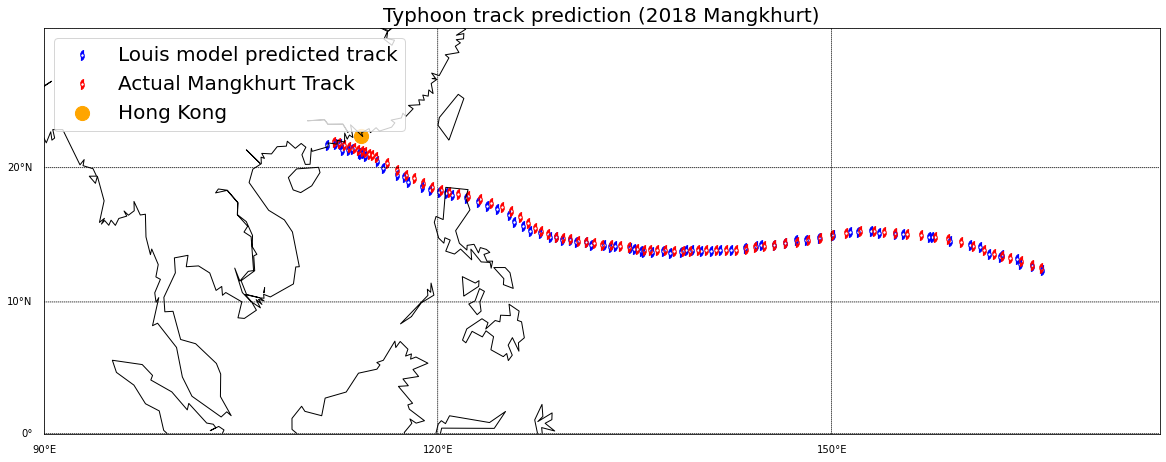

In [177]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 30, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(pred_long_mang, pred_lat_mang, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(actual_long_mang, actual_lat_mang, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual Mangkhurt Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 Mangkhurt)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_MANGKHURT.png")
plt.show()

### KONG

In [178]:
%store -r vals_kong_long
%store -r pred_kong_long
actual_long_kong = vals_kong_long
pred_long_kong = pred_kong_long
pred_lat_kong = pred_kong_lat
actual_lat_kong = vals_kong_lat

In [205]:
pred_long_kong = pred_long_kong[:,None]
actual_long_kong = actual_long_kong[:,None]
pred_lat_kong = pred_lat_kong[:,None]
actual_lat_kong = actual_lat_kong[:,None]

In [206]:
pred_kong = np.concatenate((pred_lat_kong, pred_long_kong), axis=1)

In [207]:
true_kong = np.concatenate((actual_lat_kong, actual_long_kong), axis=1)

In [208]:
print(math.sqrt(mean_squared_error(true_kong, pred_kong)))

0.3435380997809005


In [179]:
hurricane = get_hurricane()

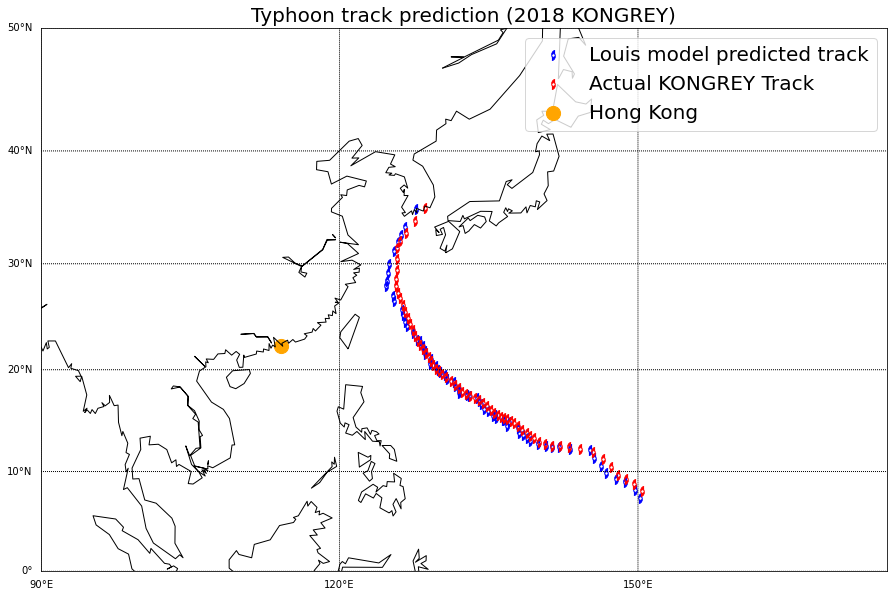

In [180]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(pred_long_kong, pred_kong_lat, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(actual_long_kong, vals_kong_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual KONGREY Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 KONGREY)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_KONGREY.png")
plt.show()

### YUTU

In [209]:
%store -r vals_yutu_long
%store -r pred_yutu_long
actual_long_yutu = vals_yutu_long
pred_long_yutu = pred_yutu_long
pred_lat_yutu = pred_yutu_lat
actual_lat_yutu = vals_yutu_lat

In [210]:
pred_long_yutu = pred_long_yutu[:,None]
actual_long_yutu = actual_long_yutu[:,None]
pred_lat_yutu = pred_lat_yutu[:,None]
actual_lat_yutu = actual_lat_yutu[:,None]

In [211]:
pred_yutu = np.concatenate((pred_lat_yutu, pred_long_yutu), axis=1)

In [212]:
true_yutu = np.concatenate((actual_lat_yutu, actual_long_yutu), axis=1)

In [214]:
print(math.sqrt(mean_squared_error(true_yutu, pred_yutu)))

0.4965086726163998


In [215]:
hurricane = get_hurricane()

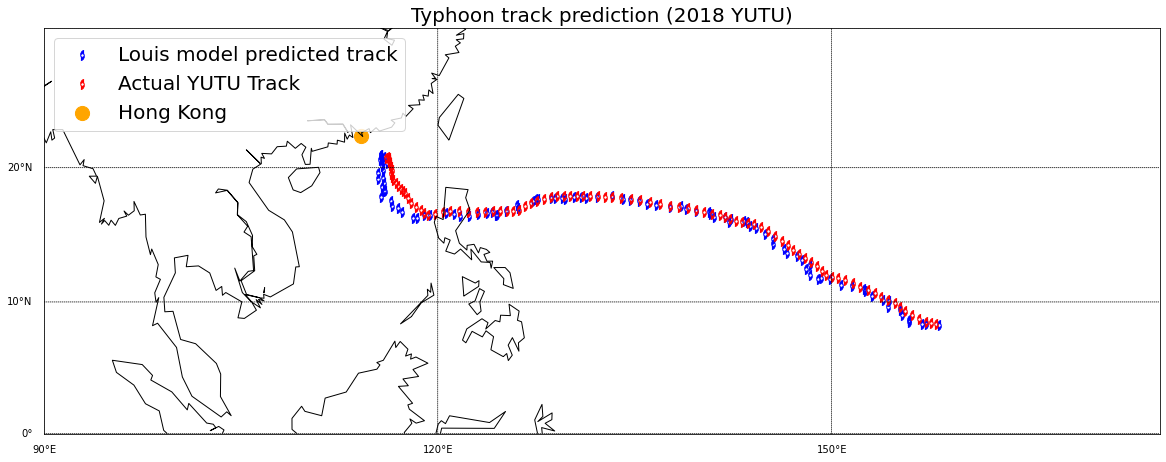

In [216]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 30, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(pred_long_yutu, pred_lat_yutu, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(actual_long_yutu, actual_lat_yutu, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual YUTU Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 YUTU)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_YUTU.png")
plt.show()

### WUTIP

In [217]:
%store -r vals_wutip_long
%store -r pred_wutip_long
actual_long_wutip = vals_wutip_long
pred_long_wutip = pred_wutip_long
pred_lat_wutip = pred_wutip_lat
actual_lat_wutip = vals_wutip_lat

In [218]:
pred_long_wutip = pred_long_wutip[:,None]
actual_long_wutip = actual_long_wutip[:,None]
pred_lat_wutip = pred_lat_wutip[:,None]
actual_lat_wutip = actual_lat_wutip[:,None]

In [219]:
pred_wutip = np.concatenate((pred_lat_wutip, pred_long_wutip), axis=1)

In [220]:
true_wutip = np.concatenate((actual_lat_wutip, actual_long_wutip), axis=1)

In [221]:
print(math.sqrt(mean_squared_error(true_wutip, pred_wutip)))

0.34598697711713916


In [185]:
hurricane = get_hurricane()

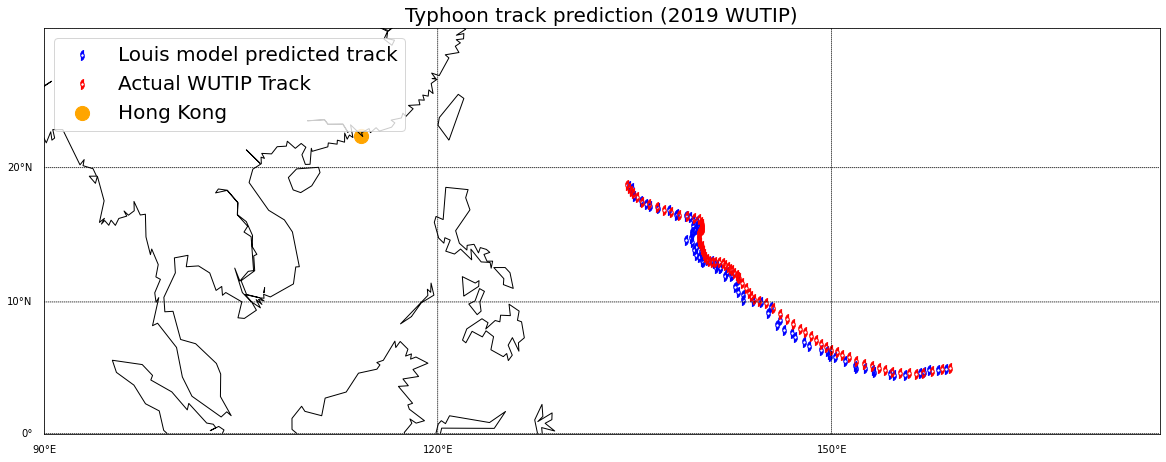

In [186]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 30, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(pred_long_wutip, pred_lat_wutip, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(actual_long_wutip, actual_lat_wutip, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual WUTIP Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2019 WUTIP)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_WUTIP.png")
plt.show()